[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Singer_Ward/kohler.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Singer_Ward/kohler.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Singer_Ward/kohler.ipynb)

#### Example of using different surface tension models and the resulting Köhler curves
Parameters for surface tension models (and aerosol physiochemical description) loosely based on laboratory experiments by RXW, described in Ward et al., in prep. (2022)

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from matplotlib import pyplot
import numpy as np

from PySDM import Formulae
from PySDM.physics import si

from open_atmos_jupyter_utils import show_plot

from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

In [3]:
# aerosol creation
FORMULAE = Formulae()
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w
aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME)

# formulae creation
formulae_bulk = Formulae(surface_tension='Constant')
formulae_ovad = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants={
        'sgm_org': 35 * si.mN / si.m,
        'delta_min': 1.75 * si.nm
    }
)
formulae_ruehl = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_m_sigma': 0.3e17 * si.J / si.m**2,
        'RUEHL_sgm_min': 35 * si.mN / si.m
    }
)
formulae_sl = Formulae(
    surface_tension='SzyszkowskiLangmuir',
    constants={
        'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_sgm_min': 35 * si.mN / si.m
    }
)

# aerosol and thermodynamic conditions
T = 300 * si.K
r_dry = 50 * si.nm
v_dry = formulae_ovad.trivia.volume(r_dry)

# plotting info
r_wet = np.logspace(np.log(50 * si.nm), np.log(2000 * si.nm), base=np.e, num=100)
v_wet = formulae_ovad.trivia.volume(r_wet)
r_wet_ticks_nm = (100, 200, 300, 500, 1000, 2000)
lines = {'Constant': '-', 'CompressedFilmOvadnevaite': '--', 'CompressedFilmRuehl': ':', 'SzyszkowskiLangmuir': '-.'}
colors = {'Constant': 'k', 'CompressedFilmOvadnevaite': 'C0', 'CompressedFilmRuehl': 'C1', 'SzyszkowskiLangmuir': 'C2'}

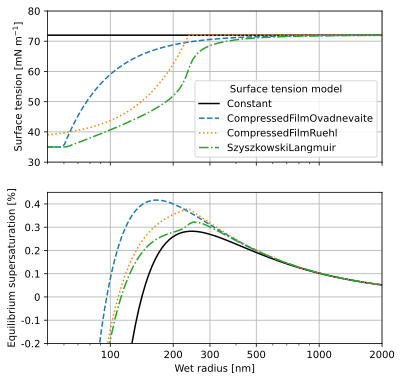

In [4]:
fig,axes = pyplot.subplots(2, 1, figsize=(6,6), sharex=True, sharey=False)

for formulae in (formulae_bulk, formulae_ovad, formulae_ruehl, formulae_sl):
    model = formulae.surface_tension.__name__
    sigma = np.ones(len(v_wet))
    if model in ("CompressedFilmRuehl", "SzyszkowskiLangmuir"):
        for j,vw in enumerate(v_wet):
            sigma[j] = formulae.surface_tension.sigma(T, vw, v_dry, aerosol.modes[0]['f_org'])
    else:
        sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, aerosol.modes[0]['f_org'])
    RH_eq = formulae.hygroscopicity.RH_eq(r_wet, T, aerosol.modes[0]['kappa'][model], r_dry**3, sigma)

    if not type(sigma) is type(v_wet):
        sigma = np.ones(len(v_wet)) * sigma
    # plot surface tension
    axes[0].plot(
        r_wet / si.nm,
        sigma / (si.mN / si.m),
        label=f"{model}", 
        color=colors[model],
        linestyle=lines[model]
    )
    
    # plot Köhler curve
    axes[1].plot(
        r_wet / si.nm, 
        (RH_eq - 1)*100, 
        color=colors[model], 
        linestyle=lines[model]
    )

# plot attributes
for ax in axes:
    ax.grid()
    ax.set_xscale('log')
    ax.set_xticks(r_wet_ticks_nm, r_wet_ticks_nm)
    ax.set_xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)

ax = axes[0]
ax.set_ylabel('Surface tension [mN m$^{-1}$]')
yticks = (30, 40, 50, 60, 70, 80)
ax.set_yticks(yticks, yticks)
ax.set_ylim(30, 80)
ax.legend(title="Surface tension model", fontsize=10, loc=4)

ax = axes[1]
ax.set_ylabel('Equilibrium supersaturation [%]')
yticks = (-.2, -.1, 0, .1, .2, .3, .4)
ax.set_yticks(yticks, yticks)
ax.set_ylim(yticks[0], .45)
ax.set_xlabel('Wet radius [nm]')

show_plot("Singer_fig1.pdf")